 # 삼성전자 주가 정보 웹스크래핑 실습

In [88]:
# 필요한 라이브러리 설치 및 임포트
!pip install requests beautifulsoup4 pandas matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 0. 웹 페이지 분석하기
- 웹 크롤링을 시작하기 전에 대상 웹사이트의 구조를 분석해야 합니다.

### 0.1 URL 엔드포인트 분석
- **대상 URL**: `https://finance.naver.com/item/sise_day.nhn?code=005930`
- **HTTP 메서드**: GET
- **설명**: 네이버 페이 증권에서 삼성전자(005930) 일별 시세 정보를 제공하는 페이지

### 0.2 요청 파라미터 분석
- **code**: 종목 코드 (005930 = 삼성전자)
- **page**: 페이지 번호 (1부터 시작)
  - 예시: `?code=005930&page=1`, `?code=005930&page=2`
  - 각 페이지마다 약 10개의 거래일 정보를 포함

### 0.3 HTML 구조 분석 (개발자 도구 활용)

#### 브라우저 개발자 도구 사용법:
1. 웹 페이지 접속 후 개발자 도구 열기
    - **Windows**: `F12` 또는 `Ctrl + Shift + I` 또는 `우클릭 > 검사`
    - **Mac**: `Cmd + Option + I` 또는 `우클릭 > 검사`
2. Elements 탭에서 원하는 데이터 위치를 찾아 HTML 구조 확인

#### 주가 정보 테이블 구조:
```html
<table class="type2">
    <tbody>
        <tr>
            <th>날짜</th>
            <th>종가</th>
            <th>전일비</th>
            <th>시가</th>
            <th>고가</th>
            <th>저가</th>
            <th>거래량</th>
        </tr>
        <tr onmouseover="mouseOver(this)" onmouseout="mouseOut(this)">
            <td>2025.10.28</td>
            <td>99,800</td>
            <td><em class="bu_p bu_pdn">하락</em>2,200</td>
            <td>100,900</td>
            <td>101,000</td>
            <td>99,200</td>
            <td>13,128,003</td>
        </tr>
        <!-- 더 많은 거래일 정보 ... -->
    </tbody>
</table>
```

### 0.4 CSS 선택자 경로
- **테이블 전체**: `table.type2`
- **주가 데이터 행**: `tr[onmouseover="mouseOver(this)"]`
- **개별 셀 구조**:
  - `td:nth-child(1)`: 날짜
  - `td:nth-child(2)`: 종가
  - `td:nth-child(3)`: 전일비
  - `td:nth-child(4)`: 시가
  - `td:nth-child(5)`: 고가
  - `td:nth-child(6)`: 저가
  - `td:nth-child(7)`: 거래량

### 0.5 전일비 분석
- 전일비는 `<span class="blind">` 태그의 텍스트로 상승/하락/보합을 구분합니다
- **상승 (빨간색)**: `<span class="blind">상승</span>`
  - 예시: `<em class="bu_p bu_pup"><span class="blind">상승</span></em>3,200`
  - 전일 대비 주가가 상승한 경우
  - 파싱 결과: `+3200`
- **하락 (파란색)**: `<span class="blind">하락</span>`
  - 예시: `<em class="bu_p bu_pdn"><span class="blind">하락</span></em>2,200`
  - 전일 대비 주가가 하락한 경우
  - 파싱 결과: `-2200`
- **보합 (검은색)**: `<span>` 태그 없음
  - 예시: `0` (단순 텍스트)
  - 전일과 동일한 가격인 경우
  - 파싱 결과: `0`

### 0.6 요청 헤더 설정
- **User-Agent** 설정 필요
  - 일부 웹사이트는 User-Agent가 없는 요청을 차단
  - 실제 브라우저처럼 보이도록 설정

### 0.7 응답 데이터 인코딩 설정
- **인코딩**: euc-kr 사용 (한글 깨짐 방지)

 ## 1. 웹 페이지 요청하기

 - 네이버 증권에서 삼성전자 주가 데이터를 가져오기

In [89]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import json
from typing import List, Dict
import os
import sys
import time
from pprint import pprint

def get_stock_page(code: str, page: int) -> str:
    """
    네이버 증권에서 특정 종목의 일별 시세 페이지 HTML을 가져오는 함수
    
    Args:
        code (str): 종목 코드 (예: '005930')
        page (int): 페이지 번호
    Returns:
        str: 웹 페이지의 HTML 내용
    """
    url = "https://finance.naver.com/item/sise_day.nhn"
    params = {"code": code, "page": page}
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/120.0.0.0'
    }
    
    try:
        response = requests.get(url, params=params, headers=headers)
        response.encoding = 'euc-kr'  # 한글 인코딩 설정
        response.raise_for_status()  # 오류가 있으면 예외를 발생시킴
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"페이지 {page} 요청 중 에러 발생: {e}")
        return ""

# 테스트: 첫 페이지 가져오기
html = get_stock_page("005930", 1)
print("HTML 일부:", html[:500])  # 처음 500자만 출력

HTML 일부: 
<html lang="ko">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=euc-kr">
<title>네이버페이 증권</title>

<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20251023172802/css/newstock.css">
<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20251023172802/css/common.css">
<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20251023172802/css/finance_header.css">
<link rel="


 ## 2. HTML 파싱하기

 - BeautifulSoup를 사용하여 HTML에서 주가 정보를 추출

In [90]:
def parse_stock_data(html: str) -> List[Dict]:
    """
    HTML에서 주가 데이터를 파싱하는 함수
    
    Args:
        html (str): 파싱할 HTML 문자열
    Returns:
        List[Dict]: 주가 정보 딕셔너리의 리스트
    """
    stocks = []
    soup = BeautifulSoup(html, 'html.parser')
    
    # onmouseover 속성이 있는 tr 태그 선택 (실제 데이터 행만 선택)
    rows = soup.find_all('tr', attrs={"onmouseover": "mouseOver(this)"})
    
    for tr in rows:
        tds = tr.find_all('td')
        if len(tds) < 7:  # 데이터 검증
            continue
        
        # 날짜 추출
        date_text = tds[0].text.strip()
        if not date_text:
            continue
        
        try:
            stock = {
                '날짜': date_text,
                '종가': int(tds[1].text.replace(',', '').strip()),
                '시가': int(tds[3].text.replace(',', '').strip()),
                '고가': int(tds[4].text.replace(',', '').strip()),
                '저가': int(tds[5].text.replace(',', '').strip()),
                '거래량': int(tds[6].text.replace(',', '').strip())
            }
            
            # 전일비 추출 (상승/하락 구분)
            span_blind = tds[2].find('span', class_='blind')
            if span_blind:
                # "상승" 또는 "하락" 텍스트로 판단
                status = span_blind.text.strip()
                # 숫자만 추출
                change_value = int(''.join(filter(str.isdigit, tds[2].text)))
                
                if status == '하락':
                    stock['전일비'] = change_value * -1
                elif status == '상승':
                    stock['전일비'] = change_value
                else:
                    stock['전일비'] = change_value
            else:
                # span 태그가 없는 경우 (보합)
                stock['전일비'] = 0
            
            stocks.append(stock)
        except (ValueError, AttributeError) as e:
            print(f"데이터 파싱 중 에러 발생: {e}")
            continue
    
    return stocks

In [91]:
# 테스트: 첫 페이지 데이터 파싱
stocks = parse_stock_data(html)
pprint(stocks)

[{'거래량': 19830309,
  '고가': 101000,
  '날짜': '2025.10.28',
  '시가': 100900,
  '저가': 99100,
  '전일비': -2500,
  '종가': 99500},
 {'거래량': 22169970,
  '고가': 102000,
  '날짜': '2025.10.27',
  '시가': 101300,
  '저가': 100600,
  '전일비': 3200,
  '종가': 102000},
 {'거래량': 18801925,
  '고가': 99000,
  '날짜': '2025.10.24',
  '시가': 97900,
  '저가': 97700,
  '전일비': 2300,
  '종가': 98800},
 {'거래량': 18488581,
  '고가': 98500,
  '날짜': '2025.10.23',
  '시가': 96800,
  '저가': 96300,
  '전일비': -2100,
  '종가': 96500},
 {'거래량': 15937611,
  '고가': 98600,
  '날짜': '2025.10.22',
  '시가': 97100,
  '저가': 95500,
  '전일비': 1100,
  '종가': 98600},
 {'거래량': 22803830,
  '고가': 99900,
  '날짜': '2025.10.21',
  '시가': 98500,
  '저가': 97300,
  '전일비': -600,
  '종가': 97500},
 {'거래량': 17589756,
  '고가': 98300,
  '날짜': '2025.10.20',
  '시가': 97900,
  '저가': 96000,
  '전일비': 200,
  '종가': 98100},
 {'거래량': 22730809,
  '고가': 99100,
  '날짜': '2025.10.17',
  '시가': 97200,
  '저가': 96700,
  '전일비': 200,
  '종가': 97900},
 {'거래량': 28141060,
  '고가': 97700,
  '날짜': '2025.10.16',
  

 ## 3. 데이터 저장하기

 - 수집한 데이터를 CSV와 JSON 형식으로 저장

In [92]:
def save_to_files(stocks: List[Dict], stock_name: str = "삼성전자", base_path: str = "./웹크롤링/주가"):
    """
    주가 정보를 CSV와 JSON 파일로 저장하는 함수
    
    Args:
        stocks: 주가 정보 리스트
        stock_name: 종목명
        base_path: 저장 경로
    """
    # 디렉토리 생성 (존재하지 않으면 생성)
    os.makedirs(base_path, exist_ok=True)
    
    # DataFrame 생성
    df = pd.DataFrame(stocks)
    
    # 수집된 주가 데이터의 날짜 범위 추출
    # 날짜 형식: 2025.10.28 -> 20251028
    start_date = df['날짜'].iloc[-1].replace('.', '')  # 가장 오래된 날짜 (마지막 행)
    end_date = df['날짜'].iloc[0].replace('.', '')     # 가장 최근 날짜 (첫 번째 행)
    
    # CSV 파일로 저장
    csv_filename = f"{stock_name}주가_{start_date}_{end_date}.csv"
    csv_file_path = os.path.join(base_path, csv_filename)
    df.to_csv(csv_file_path, encoding='utf-8', index=False)
    
    # JSON 파일로 저장
    json_filename = f"{stock_name}주가_{start_date}_{end_date}.json"
    json_file_path = os.path.join(base_path, json_filename)
    df.to_json(json_file_path, orient='records', force_ascii=False, indent=4)
    
    print(f"CSV 파일 저장 완료: {csv_file_path}")
    print(f"JSON 파일 저장 완료: {json_file_path}")
    
    return df

In [93]:
# 테스트: 첫 페이지 데이터 저장하기
df = save_to_files(stocks)
display(df)

CSV 파일 저장 완료: ./웹크롤링/주가\삼성전자주가_20251015_20251028.csv
JSON 파일 저장 완료: ./웹크롤링/주가\삼성전자주가_20251015_20251028.json


,날짜,종가,시가,고가,저가,거래량,전일비
0,2025.10.28,99500,100900,101000,99100,19830309,-2500
1,2025.10.27,102000,101300,102000,100600,22169970,3200
2,2025.10.24,98800,97900,99000,97700,18801925,2300
3,2025.10.23,96500,96800,98500,96300,18488581,-2100
4,2025.10.22,98600,97100,98600,95500,15937611,1100
5,2025.10.21,97500,98500,99900,97300,22803830,-600
6,2025.10.20,98100,97900,98300,96000,17589756,200
7,2025.10.17,97900,97200,99100,96700,22730809,200
8,2025.10.16,97700,95300,97700,95000,28141060,2700
9,2025.10.15,95000,92300,95300,92100,21050111,3400


 ## 4. 전체 과정 실행하기

 - 여러 페이지의 주가 데이터를 수집하고 저장

In [94]:
stocks = [] # 전체 주가 데이터를 저장할 빈 리스트 생성

print("삼성전자 주가 정보 수집 중...")

# 1페이지부터 10페이지까지 반복하여 데이터 수집
for page in range(1, 11):  # 1~10 페이지 수집 (총 약 100개의 거래일 정보)
    # 현재 페이지의 HTML 가져오기
    html = get_stock_page("005930", page)
    
    # HTML을 성공적으로 가져온 경우에만 파싱 진행
    if html:
        # HTML에서 주가 데이터 추출
        page_stocks = parse_stock_data(html)
        
        # 추출한 데이터를 전체 리스트에 추가
        stocks.extend(page_stocks)
        
        # 현재 페이지의 수집 결과 출력
        print(f"페이지 {page}: {len(page_stocks)}개의 거래일 정보 수집 완료")
        
        # 서버 부하 방지 및 안정적인 크롤링을 위한 대기 시간 (0.5초)
        time.sleep(0.5)

# 수집한 데이터가 없는 경우 에러 처리
if not stocks:
    print("주가 정보를 가져오는데 실패했습니다.")
    sys.exit(1)  # 프로그램 종료 (에러 코드 1)

# 수집 완료 메시지 출력
print(f"\n총 {len(stocks)}개의 거래일 정보를 수집했습니다.")

# 데이터 저장 시도
try:
    df = save_to_files(stocks)
except Exception as e:
    print(f"데이터 저장 중 에러 발생: {e}")

삼성전자 주가 정보 수집 중...
페이지 1: 10개의 거래일 정보 수집 완료
페이지 2: 10개의 거래일 정보 수집 완료
페이지 3: 10개의 거래일 정보 수집 완료
페이지 4: 10개의 거래일 정보 수집 완료
페이지 5: 10개의 거래일 정보 수집 완료
페이지 6: 10개의 거래일 정보 수집 완료
페이지 7: 10개의 거래일 정보 수집 완료
페이지 8: 10개의 거래일 정보 수집 완료
페이지 9: 10개의 거래일 정보 수집 완료
페이지 10: 10개의 거래일 정보 수집 완료

총 100개의 거래일 정보를 수집했습니다.
CSV 파일 저장 완료: ./웹크롤링/주가\삼성전자주가_20250530_20251028.csv
JSON 파일 저장 완료: ./웹크롤링/주가\삼성전자주가_20250530_20251028.json


 ## 5. 데이터 시각화

 - 수집한 주가 데이터를 그래프로 표현

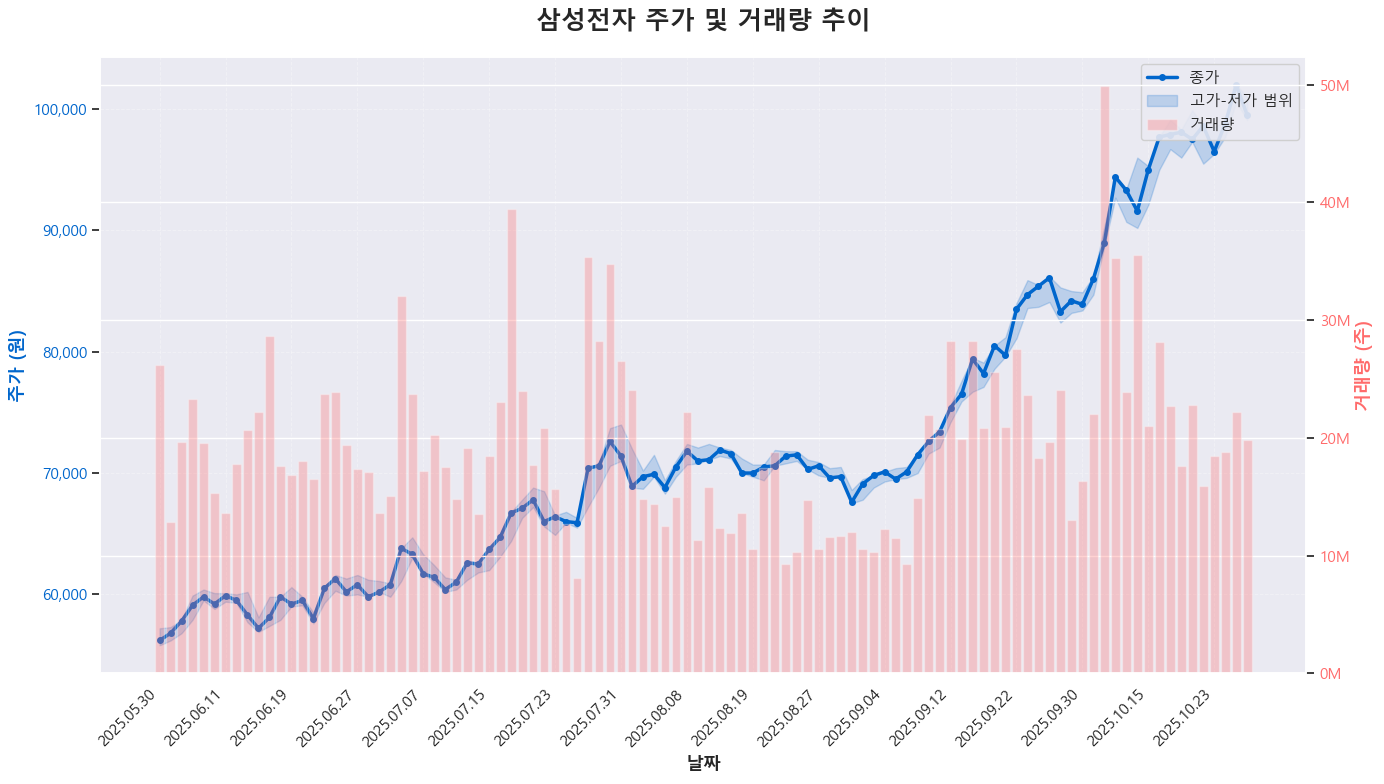


📊 삼성전자 주가 기본 통계
최고가:         102,000원
최저가:          55,800원
평균 종가:       72,178원
평균 거래량: 19,490,189주
기간:        2025.10.28 ~ 2025.05.30


In [95]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

# 날짜 기준 오름차순 정렬 (과거 → 현재)
df = df.sort_values('날짜').reset_index(drop=True)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(14, 8))

# 주가 라인 차트 (왼쪽 y축)
color_price = '#0066CC'
ax1.plot(df['날짜'], df['종가'], 
        marker='o', 
        markersize=4,
        linestyle='-', 
        linewidth=2.5, 
        color=color_price,
        label='종가',
        zorder=3)

# 고가/저가 영역 표시
ax1.fill_between(range(len(df)), df['고가'], df['저가'], 
                alpha=0.2, color=color_price, label='고가-저가 범위', zorder=2)

# 왼쪽 y축 설정 (주가)
ax1.set_xlabel('날짜', fontsize=13, fontweight='bold')
ax1.set_ylabel('주가 (원)', fontsize=13, fontweight='bold', color=color_price)
ax1.tick_params(axis='y', labelcolor=color_price)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# 오른쪽 y축 생성 (거래량)
ax2 = ax1.twinx()
color_volume = '#FF6B6B'
ax2.bar(range(len(df)), df['거래량'], 
        alpha=0.3, 
        color=color_volume, 
        label='거래량',
        zorder=1)

# 오른쪽 y축 설정 (거래량)
ax2.set_ylabel('거래량 (주)', fontsize=13, fontweight='bold', color=color_volume)
ax2.tick_params(axis='y', labelcolor=color_volume)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000000):.0f}M'))

# 제목
ax1.set_title('삼성전자 주가 및 거래량 추이', fontsize=18, fontweight='bold', pad=20)

# x축 설정 (너무 많은 날짜 표시 방지)
step = max(1, len(df) // 15)  # 최대 15개 정도의 날짜만 표시
ax1.set_xticks(range(0, len(df), step))
ax1.set_xticklabels(df['날짜'][::step], rotation=45, ha='right')

# 그리드 설정
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax1.set_axisbelow(True)  # 그리드를 차트 뒤로

# 범례 통합
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11, framealpha=0.9)

# 여백 조정
plt.tight_layout()
plt.show()

# 기본 통계 정보 (더 보기 좋게)
print("\n" + "="*50)
print("📊 삼성전자 주가 기본 통계")
print("="*50)
print(f"최고가:      {df['고가'].max():>10,}원")
print(f"최저가:      {df['저가'].min():>10,}원")
print(f"평균 종가:   {df['종가'].mean():>10,.0f}원")
print(f"평균 거래량: {df['거래량'].mean():>10,.0f}주")
print(f"기간:        {df['날짜'].iloc[-1]} ~ {df['날짜'].iloc[0]}")
print("="*50)